In [1]:
from spice.models import IcosphereModel
from spice.models.mesh_transform import add_rotation, evaluate_rotation
from spice.models.spots import add_spherical_harmonic_spots, add_spots, add_spot
from spice.plots import plot_3D, plot_3D_mesh_and_spectrum
from spice.spectrum import simulate_observed_flux
import astropy.units as u
import jax.numpy as jnp
import numpy as np
from transformer_payne import TransformerPayne
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm

from jax import config

In [2]:
tp = TransformerPayne.download()

In [3]:
models = {}

In [4]:
models[1000] = IcosphereModel.construct(1000, 1.0, 1.0, tp.to_parameters(),
                                  tp.stellar_parameter_names, override_log_g=False)

models[5000] = IcosphereModel.construct(5000, 1.0, 1.0, tp.to_parameters(),
                                  tp.stellar_parameter_names, override_log_g=False)

models[20000] = IcosphereModel.construct(20000, 1.0, 1.0, tp.to_parameters(),
                                  tp.stellar_parameter_names, override_log_g=False)

In [5]:
from collections import defaultdict
from spice.models.mesh_view import get_mesh_view
from spice.models.utils import inclination_to_los_axis, lat_to_theta, lon_to_phi, velocity_to_period

rs = [1000, 5000, 20000]
vs = [20, 50, 100]
models_with_vs = defaultdict(dict)

timestamps = {}

for v in vs:
    timestamps[v] = jnp.linspace(0, velocity_to_period(v, 1.0), 10)

# Convert inclination to LOS vector
for r in rs:
    for v in vs:
        models_with_vs[r][v] = add_rotation(models[r], v)

SPOT_RADIUS = 25.

for r in rs:
    for v in vs:
        models_with_vs[r][v] = add_spots(models_with_vs[r][v],
                                        spot_center_thetas=jnp.array([lat_to_theta(lat_deg) for lat_deg in [-30, 0, 30, 60]]),
                                        spot_center_phis=jnp.array([lon_to_phi(lon_deg) for lon_deg in [-90, 0, 90, 180]]),
                                        spot_radii=jnp.array(4*[SPOT_RADIUS]),
                                        parameter_deltas=jnp.array(4*[1.5]),
                                        parameter_indices=jnp.array(4*[27]),
                                        smoothness=jnp.array(4*[0.5]))


In [6]:
evaluated_models = defaultdict(dict)
for r in rs:
    for v in vs:
        evaluated_models[r][v] = [evaluate_rotation(models_with_vs[r][v], t) for t in tqdm(timestamps[v])]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 3245.36it/s]


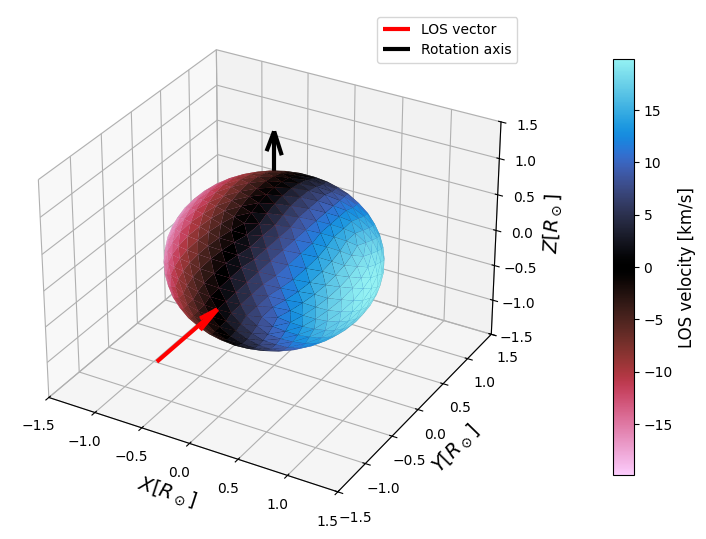

In [7]:
fig, _ = plot_3D(evaluated_models[1000][20][0], 'los_velocities');

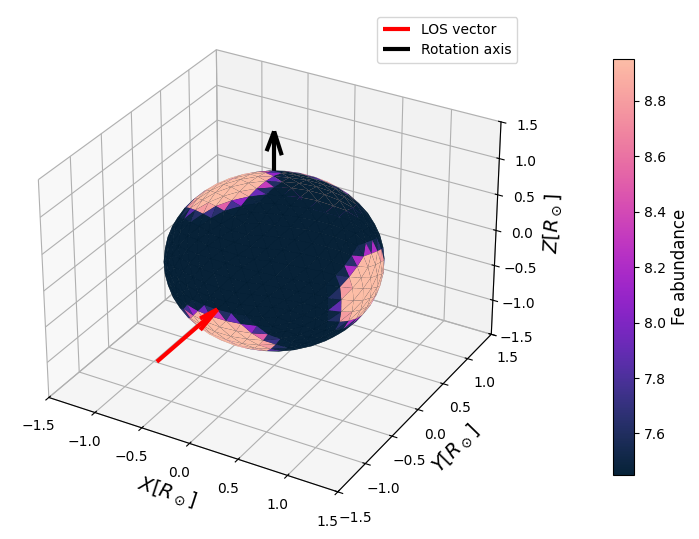

In [8]:
fig, _ = plot_3D(evaluated_models[1000][20][0], 27, property_label='Fe abundance');

In [9]:
vws = jnp.linspace(5000, 5002, 1000)
line_fluxes = defaultdict(dict)

for r in tqdm(rs, desc="Resolution"):
    for v in tqdm(vs, desc="Velocity", leave=False):
        line_fluxes[r][v] = simulate_observed_flux(tp.intensity, evaluated_models[r][v][0], jnp.log10(vws), chunk_size=2048)

Resolution:   0%|                                                                                                                                               | 0/3 [00:00<?, ?it/s]/home/100/mj8805/scr/mj8805/miniconda3/envs/astro/lib/python3.12/site-packages/jax/_src/linear_util.py:370: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in logspace is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  ans = _fun(*args, **kwargs)
/home/100/mj8805/scr/mj8805/miniconda3/envs/astro/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:122: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variab

In [10]:
import matplotlib.pyplot as plt

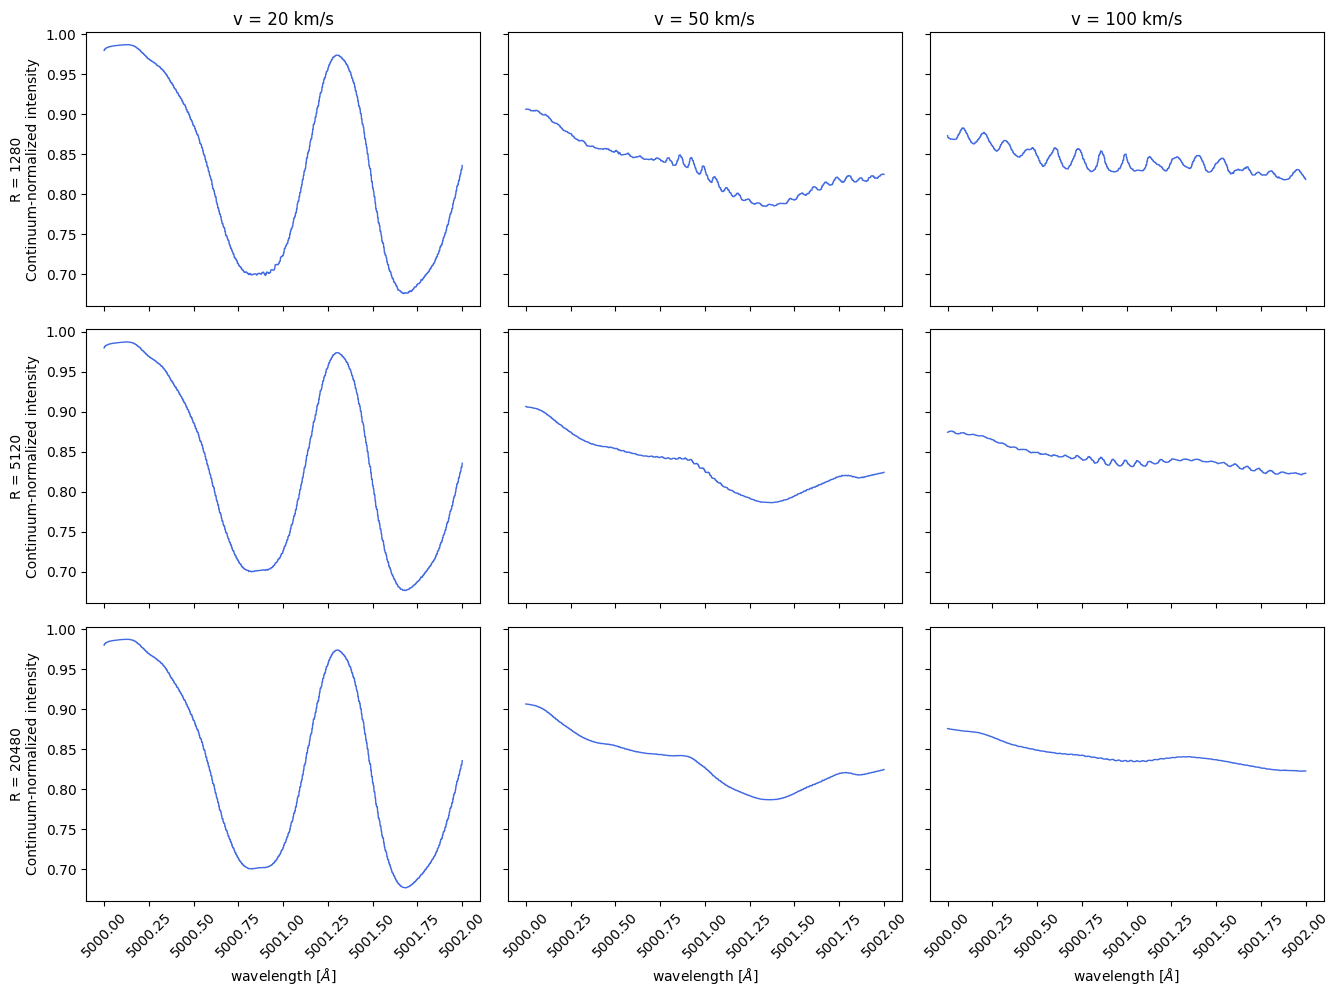

In [11]:
import matplotlib as mpl
import cmasher as cmr

# Create a figure with subplots for each resolution and velocity
fig, axs = plt.subplots(nrows=len(rs), ncols=len(vs), figsize=(15, 10), 
                        sharex=True, sharey=True, squeeze=False)

# Loop through each resolution and velocity
for i, r in enumerate(rs):
    for j, v in enumerate(vs):
        ax = axs[i, j]
        
        # Get the spectra for this resolution and velocity
        spectra = line_fluxes[r][v]
        n_lines = len(spectra)
        
        # Create colormap
        cmap = cmr.bubblegum
        colors = cmap(np.linspace(0, 1, n_lines))
        
        # Plot each spectrum with a different color
        ax.plot(vws, line_fluxes[r][v][:, 0]/line_fluxes[r][v][:, 1], color='royalblue', linewidth=1.)
        
        # Add labels to the first row and column
        if i == 0:
            ax.set_title(f'v = {v} km/s')
        if j == 0:
            ax.set_ylabel(f'R = {len(models[r].areas)}\nContinuum-normalized intensity')
        
        # Only add x-label to the bottom row
        if i == len(rs) - 1:
            ax.set_xlabel(r'wavelength [$\AA$]')
            ax.tick_params(axis='x', rotation=45)

# Create a colorbar
norm = mpl.colors.Normalize(vmin=min([t[0]/3600 for t in timestamps.values()]), 
                           vmax=max([t[-1]/3600 for t in timestamps.values()]))

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.9, 1])

In [12]:
fig.savefig('resolution_efects_line_fluxes.png')